# DS-SF-36 | Class | 17 | Predicting Energy Loads

In [74]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, ensemble
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import linear_model

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'dataset-energy-efficiency.csv'))

df.head()

,RC,SA,WA,RA,OH,OR,GA,GAD,HL,CL
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Split into 70/30 train/test.

In [3]:
train_df, test_df = train_test_split(df, test_size = 0.3)

# EDA

In [11]:
test_df.shape

(231, 10)

In [4]:
train_df.shape

(537, 10)

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RC,537.0,0.763408,0.106448,0.62,0.66,0.74,0.86,0.98
SA,537.0,672.540968,88.595147,514.50,588.00,686.00,759.50,808.50
WA,537.0,318.226257,44.141791,245.00,294.00,318.50,343.00,416.50
RA,537.0,177.157356,45.342377,110.25,122.50,220.50,220.50,220.50
OH,537.0,5.220670,1.751386,3.50,3.50,3.50,7.00,7.00
OR,537.0,3.484171,1.114788,2.00,2.00,3.00,4.00,5.00
GA,537.0,0.238082,0.135346,0.00,0.10,0.25,0.40,0.40
GAD,537.0,2.741155,1.577016,0.00,1.00,3.00,4.00,5.00
HL,537.0,22.105791,10.037286,6.01,12.97,18.19,31.29,42.96
CL,537.0,24.358976,9.390379,10.94,15.59,21.33,32.83,48.03


### HL and CL are highly correlated.  There are also other variables that are highly correlated at over 80%.

In [6]:
train_df.corr().round(3)

,RC,SA,WA,RA,OH,OR,GA,GAD,HL,CL
RC,1.000,-0.992,-0.209,-0.868,0.828,0.007,-0.003,0.024,0.624,0.644
SA,-0.992,1.000,0.201,0.879,-0.858,-0.009,0.004,-0.025,-0.658,-0.681
WA,-0.209,0.201,1.000,-0.290,0.277,0.005,-0.002,-0.031,0.453,0.424
RA,-0.868,0.879,-0.290,1.000,-0.973,-0.011,0.005,-0.010,-0.863,-0.872
OH,0.828,-0.858,0.277,-0.973,1.000,0.017,-0.004,0.015,0.888,0.901
OR,0.007,-0.009,0.005,-0.011,0.017,1.000,-0.018,-0.012,0.020,0.047
GA,-0.003,0.004,-0.002,0.005,-0.004,-0.018,1.000,0.290,0.274,0.205
GAD,0.024,-0.025,-0.031,-0.010,0.015,-0.012,0.290,1.000,0.116,0.075
HL,0.624,-0.658,0.453,-0.863,0.888,0.020,0.274,0.116,1.000,0.976
CL,0.644,-0.681,0.424,-0.872,0.901,0.047,0.205,0.075,0.976,1.000


### no missing values in the dataset.

In [7]:
train_df.isnull().sum()

RC     0
SA     0
WA     0
RA     0
OH     0
OR     0
GA     0
GAD    0
HL     0
CL     0
dtype: int64

In [8]:
def NUM_EDA_graph(variable):
    print('EDA Analysis for variable: {}'.format(variable))
    fig=plt.figure(figsize=(10,4))
    
    ax1=fig.add_subplot(131)
    train_df[variable].plot.box()
    ax1.set_title('Box Plot')
    ax1.set_ylabel('Value')

    ax2=fig.add_subplot(132)
    train_df[variable].plot.hist(bins=10)
    ax2.set_xlabel(variable)
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram')
    
    ax3=fig.add_subplot(133)
    train_df.plot.scatter(x=variable, y='HL', ax=ax3)
    ax3.set_xlabel(variable)
    ax3.set_ylabel('HL')
    ax3.set_title('Scatter')
    
#     fig.suptitle('Two Charts')
    plt.tight_layout()
    plt.show()

EDA Analysis for variable: RC


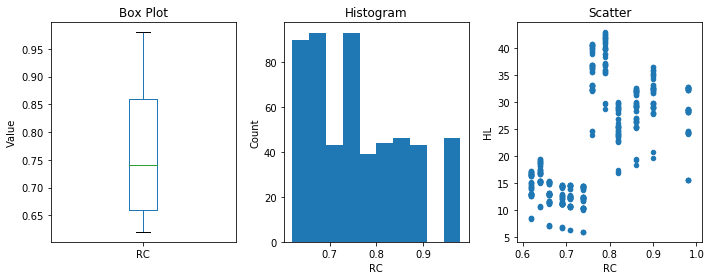

EDA Analysis for variable: SA


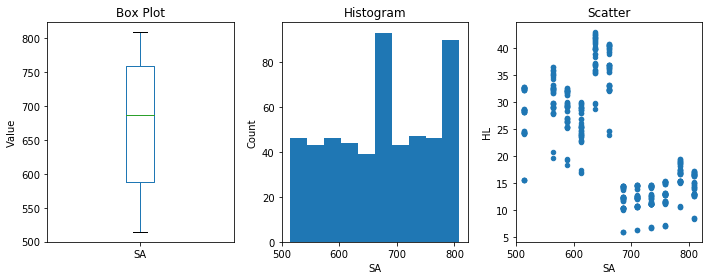

EDA Analysis for variable: WA


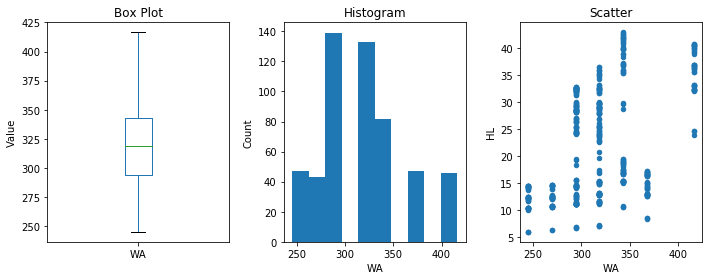

EDA Analysis for variable: RA


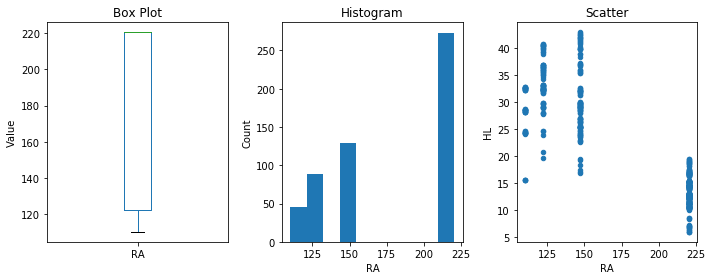

EDA Analysis for variable: OH


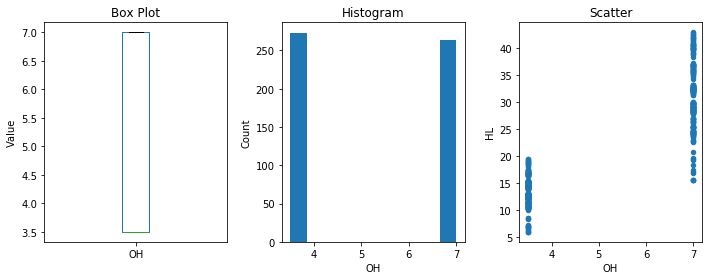

EDA Analysis for variable: OR


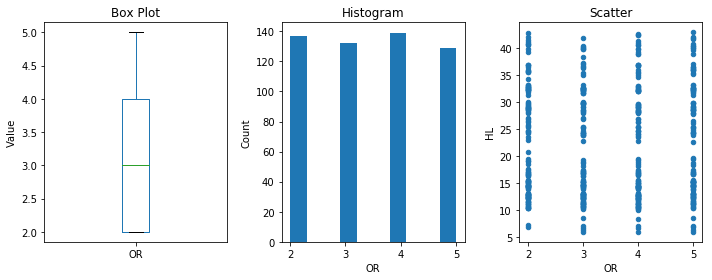

EDA Analysis for variable: GA


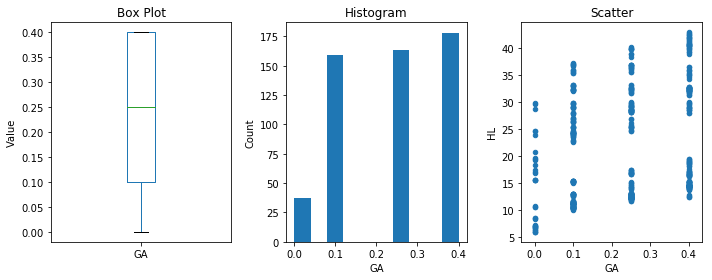

EDA Analysis for variable: GAD


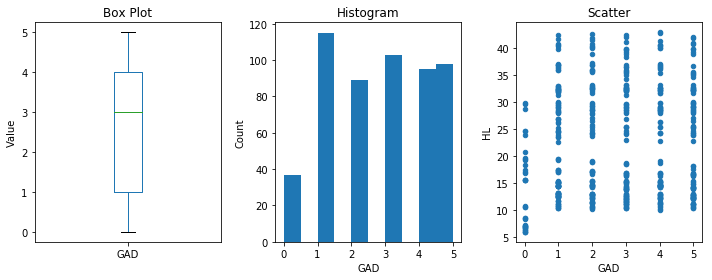

In [9]:
lst=['RC','SA','WA','RA','OH','OR','GA','GAD']
for i in lst:
    NUM_EDA_graph(i)

### A few variables may be coded as categorical variable, OH/OR/GA/GAD.

In [10]:
for i in lst:
    print('\nUnique values for {}'.format(i))
    print(train_df[i].unique())


Unique values for RC
[ 0.69  0.76  0.74  0.98  0.66  0.71  0.82  0.79  0.64  0.62  0.9   0.86]

Unique values for SA
[ 735.   661.5  686.   514.5  759.5  710.5  612.5  637.   784.   808.5
  563.5  588. ]

Unique values for WA
[ 294.   416.5  245.   318.5  269.5  343.   367.5]

Unique values for RA
[ 220.5   122.5   110.25  147.  ]

Unique values for OH
[ 3.5  7. ]

Unique values for OR
[4 2 3 5]

Unique values for GA
[ 0.4   0.25  0.1   0.  ]

Unique values for GAD
[4 3 5 1 2 0]


## Initial Model

In [17]:
X = train_df.drop(['HL','CL'], axis=1)
X = sm.add_constant(X)
y=train_df.HL

In [20]:
X

,const,RC,SA,WA,RA,OH,OR,GA,GAD
706,1.0,0.69,735.0,294.0,220.50,3.5,4,0.40,4
644,1.0,0.76,661.5,416.5,122.50,7.0,2,0.40,3
410,1.0,0.74,686.0,245.0,220.50,3.5,4,0.25,3
722,1.0,0.98,514.5,294.0,110.25,7.0,4,0.40,5
85,1.0,0.66,759.5,318.5,220.50,3.5,3,0.10,1
...,...,...,...,...,...,...,...,...,...
491,1.0,0.86,588.0,294.0,147.00,7.0,5,0.25,5
86,1.0,0.66,759.5,318.5,220.50,3.5,4,0.10,1
727,1.0,0.90,563.5,318.5,122.50,7.0,5,0.40,5
253,1.0,0.82,612.5,318.5,147.00,7.0,3,0.10,5


# Model_baseline has all variables

In [25]:
model_baseline = sm.OLS(y,X).fit()

model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HL   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     855.2
Date:                Mon, 21 Aug 2017   Prob (F-statistic):          1.04e-283
Time:                        20:00:11   Log-Likelihood:                -1325.8
No. Observations:                 537   AIC:                             2668.
Df Residuals:                     529   BIC:                             2702.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.6757     22.053      4.021      0.000      45.354     131.998
RC           -65.8596     11.925     -5.523      0.000     -89.286     -42.433
SA            -0.0672      0.016     -4.322      0.000      -0.098      -0.037
WA             0.0387      0.005      8.596      0.000       0.030       0.048
RA            -0.0530      0.009     -6.068      0.000      -0.070      -0.036
OH             3.8899      0.396      9.818      0.000       3.112       4.668
OR             0.0879      0.112      0.788      0.431      -0.131       0.307
GA            19.9389      0.960     20.767      0.000      18.053      21.825
GAD            0.2123      0.082      2.574      0.010       0.050       0.374
==============================================================================
Omnibus:                       16.865   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.893
Skew:                           0.079   Prob(JB):                     1.61e-08
Kurtosis:                       4.257   Cond. No.                     2.45e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.3e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## dropping OR which was non significant in the baseline model

In [26]:
X = train_df.drop(['HL','CL','OR'], axis=1)
X = sm.add_constant(X)
y=train_df.HL
model1 = sm.OLS(y,X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HL   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     998.3
Date:                Mon, 21 Aug 2017   Prob (F-statistic):          4.31e-285
Time:                        20:05:08   Log-Likelihood:                -1326.1
No. Observations:                 537   AIC:                             2666.
Df Residuals:                     530   BIC:                             2696.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.7481     22.045      4.026      0.000      45.442     132.054
RC           -65.7739     11.921     -5.518      0.000     -89.191     -42.357
SA            -0.0670      0.016     -4.312      0.000      -0.098      -0.036
WA             0.0387      0.005      8.583      0.000       0.030       0.047
RA            -0.0528      0.009     -6.056      0.000      -0.070      -0.036
OH             3.8989      0.396      9.848      0.000       3.121       4.677
GA            19.9277      0.960     20.765      0.000      18.042      21.813
GAD            0.2118      0.082      2.569      0.010       0.050       0.374
==============================================================================
Omnibus:                       17.136   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.724
Skew:                           0.081   Prob(JB):                     1.06e-08
Kurtosis:                       4.271   Cond. No.                     2.45e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.3e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

 ## lasso

In [47]:
X.columns

Index([u'const', u'RC', u'SA', u'WA', u'RA', u'OH', u'GA', u'GAD'], dtype='object')

In [48]:
alphas = [1, .5, 1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
for i in alphas:
    model_lasso=linear_model.Lasso(alpha=i, normalize=True).fit(X,y)
    print('alpha={}'.format(i))
    print(map(lambda coef: '{:2.2f}'.format(coef), model_lasso.coef_))

alpha=1
['0.00', '0.00', '-0.00', '0.00', '-0.00', '0.00', '0.00', '0.00']
alpha=0.5
['0.00', '0.00', '-0.00', '0.00', '-0.00', '0.00', '0.00', '0.00']
alpha=0.1
['0.00', '0.00', '-0.00', '0.01', '-0.00', '3.70', '3.39', '0.00']
alpha=0.01
['0.00', '-0.00', '-0.00', '0.05', '-0.00', '4.64', '18.57', '0.09']
alpha=0.001
['0.00', '-31.63', '-0.00', '0.01', '-0.08', '4.60', '19.78', '0.20']
alpha=1e-05
['0.00', '-65.38', '-0.09', '0.06', '-0.01', '3.91', '19.93', '0.21']
alpha=1e-07
['0.00', '-65.73', '-0.09', '0.06', '-0.01', '3.90', '19.93', '0.21']
alpha=1e-09
['0.00', '-65.74', '-0.09', '0.06', '-0.01', '3.90', '19.93', '0.21']
alpha=1e-11
['0.00', '-65.74', '-0.09', '0.06', '-0.01', '3.90', '19.93', '0.21']


In [60]:
cv = 5 # 5-fold CV
alpha = [1, .5, 0.4, 0.3, 0.2, 0.1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

gs = model_selection.GridSearchCV(
    estimator = linear_model.Lasso(),
    param_grid = {'alpha': alpha, 'normalize': [True] },
    cv = model_selection.KFold(n_splits = cv, shuffle = True, random_state = 12345)
)

gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': [True], 'alpha': [1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [61]:
gs.cv_results_

{'mean_fit_time': array([ 0.00299997,  0.00300002,  0.00320001,  0.        ,  0.00300002,
         0.        ,  0.        ,  0.        ,  0.00620003,  0.00300002,
         0.00320001]),
 'mean_score_time': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00320001,  0.        ,  0.        ,  0.        ]),
 'mean_test_score': array([-0.0083956 , -0.0083956 ,  0.09793909,  0.3994428 ,  0.61474299,
         0.79964949,  0.79964949,  0.91036672,  0.91545481,  0.91663271,
         0.91665492]),
 'mean_train_score': array([ 0.        ,  0.        ,  0.10540781,  0.40457048,  0.6182581 ,
         0.80248277,  0.80248277,  0.91232119,  0.91778762,  0.91883561,
         0.91884674]),
 'param_alpha': masked_array(data = [1 0.5 0.4 0.3 0.2 0.1 0.1 0.01 0.001 0.0001 1e-05],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'param_normalize': masked_array(data = [True True Tr

In [62]:
gs.best_score_

0.91665492132470516

In [63]:
gs.best_params_

{'alpha': 1e-05, 'normalize': True}

In [64]:
gs.best_estimator_

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

## optimized lasso parameter with alpha=1e-5

In [66]:
X.columns

Index([u'const', u'RC', u'SA', u'WA', u'RA', u'OH', u'GA', u'GAD'], dtype='object')

In [67]:
model_lasso_optimized=linear_model.Lasso(alpha=i, normalize=True).fit(X,y)

In [69]:
print(map(lambda coef: '{:2.2f}'.format(coef), model_lasso.coef_))

['0.00', '-65.74', '-0.09', '0.06', '-0.01', '3.90', '19.93', '0.21']


In [71]:
X = train_df.drop(['HL','CL','OR'], axis=1)
X = sm.add_constant(X)
y=train_df.HL
model1 = sm.OLS(y,X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HL   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     998.3
Date:                Mon, 21 Aug 2017   Prob (F-statistic):          4.31e-285
Time:                        21:04:13   Log-Likelihood:                -1326.1
No. Observations:                 537   AIC:                             2666.
Df Residuals:                     530   BIC:                             2696.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.7481     22.045      4.026      0.000      45.442     132.054
RC           -65.7739     11.921     -5.518      0.000     -89.191     -42.357
SA            -0.0670      0.016     -4.312      0.000      -0.098      -0.036
WA             0.0387      0.005      8.583      0.000       0.030       0.047
RA            -0.0528      0.009     -6.056      0.000      -0.070      -0.036
OH             3.8989      0.396      9.848      0.000       3.121       4.677
GA            19.9277      0.960     20.765      0.000      18.042      21.813
GAD            0.2118      0.082      2.569      0.010       0.050       0.374
==============================================================================
Omnibus:                       17.136   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.724
Skew:                           0.081   Prob(JB):                     1.06e-08
Kurtosis:                       4.271   Cond. No.                     2.45e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.3e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## random forest

In [79]:
cv = 5 # 5-fold CV
max_features=[2,3,4,5,6]
min_samples_leaf = [5,10,15,20,25,30]
oob_score = [True, False]

gs1 = model_selection.GridSearchCV(
    estimator = ensemble.RandomForestRegressor(),
    param_grid = {'max_features': max_features, 
                  'min_samples_leaf': min_samples_leaf,
                  'oob_score': oob_score},
    cv = model_selection.KFold(n_splits = cv, shuffle = True, random_state = 12345)
)

gs1.fit(X, y)

C:\Users\jmiller16\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [2, 3, 4, 5, 6], 'oob_score': [True, False], 'min_samples_leaf': [5, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [93]:
gs1.cv_results_

{'mean_fit_time': array([ 0.03160005,  0.02839999,  0.02199993,  0.01739998,  0.02179995,
         0.03120003,  0.03119998,  0.02839999,  0.02480001,  0.02800002,
         0.01580005,  0.01580005,  0.01540008,  0.02460003,  0.03179998,
         0.03119998,  0.01860008,  0.01560006,  0.02520003,  0.03099999,
         0.01879997,  0.01559992,  0.025     ,  0.025     ,  0.01859999,
         0.03140001,  0.01539998,  0.02200007,  0.01880002,  0.025     ,
         0.04059997,  0.05299997,  0.03140006,  0.02179999,  0.02520003,
         0.01559997,  0.02199998,  0.0158    ,  0.025     ,  0.01560001,
         0.02820001,  0.0158    ,  0.01900001,  0.03119998,  0.01860003,
         0.01579995,  0.01879997,  0.03120008,  0.03120003,  0.01880002,
         0.02179999,  0.02199998,  0.02179999,  0.01880002,  0.02519999,
         0.01539998,  0.03119998,  0.01580005,  0.01580005,  0.02480001]),
 'mean_score_time': array([ 0.00299997,  0.00599999,  0.01000004,  0.01340003,  0.00940003,
         0.  

In [83]:
gs1.best_score_

0.98943657947404895

In [84]:
gs1.best_params_

{'max_features': 6, 'min_samples_leaf': 5, 'oob_score': True}

In [86]:
gs1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [90]:
model_rf=ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False).fit(X,y)

In [92]:
sorted(zip(model_rf.feature_importances_, X.columns.values), reverse = True)

[(0.34510256741205386, 'RC'),
 (0.2419530765169246, 'OH'),
 (0.20678914396742099, 'SA'),
 (0.081232912657048489, 'RA'),
 (0.061016067542637775, 'GA'),
 (0.036388284596383533, 'WA'),
 (0.02751794730753071, 'GAD'),
 (0.0, 'const')]